#1η ομαδική άσκηση


##Θεωρητικό μέρος


*α) Ποιο είναι το πρόβλημα και ποιες είναι οι κύριες ιδέες που διαπραγματεύεται το άρθρο αυτό;* 
<br>
<br>
Το πρόβλημα που αναφέρεται είναι η συμπίεση εικόνων. Συγκεκριμένα αναφέρεται ότι οι εικόνες έχουν κατά βάση την ιδιότητα διπλανά pixels να έχουν μεγάλη συσχέτιση. Ως αποτέλεσμα η αποθήκευση τιμών για κάθε pixel ανεξάρτητα διατηρεί μεγάλο όγκο πληροφορίας που δεν είναι οφέλιμη και αντί αυτού θα μπορούσε να υπολογιστεί η τιμή ενός pixel από τη διαφορά του από προηγούμενα.
<br>
<br>
*β) Ποιος είναι ο σκοπός του φίλτρου Gauss στην κατασκευή της πυραμίδας; Τι θα συνέβαινε αν
χρησιμοποιήθηκε μόνο υποδειγματοληψία; κείμενο σε πλάγια γραφή* 
<br>
<br>
*γ) Πώς χρησιμοποιείται η πυραμίδα Laplacian για την επίλυση του προβλήματος που αναφέρεται
στο άρθρο; Γιατί αυτή η αναπαράσταση εικόνας είναι καλύτερη από την πυραμίδα Gauss στο
πλαίσιο της εργασίας που διαπραγματεύεται το άρθρο;* 
<br>
<br>
*δ) Περιγράψτε πώς να ανακτήσετε την εικόνα χρησιμοποιώντας μόνο την πυραμίδα Laplacian. Διατυπώστε την απάντησή σας χρησιμοποιώντας μια εξίσωση που περιγράφει αυτήν τη διαδικασία. Θα μπορέσουμε να ανακτήσουμε τέλεια την αρχική εικόνα;*
<br>

##Εργαστηριακό μέρος

### Υλοποίηση Αλγορίθμου

In [ ]:
import numpy as np

In [ ]:
import urllib.request
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

####α) Συνάρτηση h = GKernel(a), η οποία θα δημιουργεί ένα Generating Kernel,
εξαρτώμενο από την παράμετρο ‘a’

In [ ]:
def GKernel(a):
  b = 1/4
  c = 1/4 - a/2
  w = np.array([c,b,a,b,c])
  neww = np.reshape(w,(1,w.size)) 
  w_transpose = np.transpose(neww)
  return np.matmul(w_transpose,neww)

####β) Συνάρτηση I_out = GREDUCE(I, h)

In [ ]:
# def GREDUCE(I,h):
#   g_l = np.zeros(((I.shape[0]+1)//2,(I.shape[1]+1)//2))
#   for i in range (g_l.shape[0]):
#     for j in range (g_l.shape[1]): 
#       for m in range(-2,3):
#         for n in range(-2,3):
#           g_l[i,j] += h[m,n] * I[2*i+m-1, 2*j+n-1]
#   return g_l

def GREDUCE(I,h):
  filtered_img = cv2.filter2D(I,-1,h)
  I_reduced = filtered_img[0::2,0::2]
  return I_reduced


#### γ) Συνάρτηση G = GPyramid(I, a, depth) όπου δέχεται ως είσοδο μία εικόνα Ι, την παράμετρο ‘a’, το επιθυμητό βάθος για την πυραμίδα ’depth’ και επιστρέφει την Gaussian pyramid και την αποθηκεύει.

In [ ]:
def GPyramid(I,a,depth):
  h = GKernel(a)
  L = [I]
  for n in range(depth-1):
    Lnext = GREDUCE(L[n],h)
    L.append(Lnext)
  return (L,h)

####δ) Συνάρτηση I_out = GEXPAND (I, h) την εξίσωση (2) (σελίδα άρθρου 534).

In [ ]:
def GEXPAND(I,h):
  new_img = cv2.resize(I, (I.shape[0]*2,I.shape[1]*2), interpolation=cv2.INTER_AREA)
  return cv2.filter2D(new_img,-1,h)

####ε) Συνάρτηση L = LPyramid(I, a, depth) όπου επιστρέφει την Laplacian πυραμίδα της εικόνας I

In [ ]:
def LPyramid(I, a, depth):
  (L,h) = GPyramid(I, a, depth)
  H = [L[depth-1]]
  for n in range(depth-1):
    interpolated = GEXPAND(L[depth-n-1],h)
    difference = L[depth-n-2] - interpolated + 128
    H.append(difference)
  H.reverse()
  return H

####στ) Συνάρτηση I_out = L_Pyramid_Decode(L,a) όπου λαμβάνει την Laplacian
πυραμίδα L και την παράμετρο 'a' που χρησιμοποιήθηκε για τη δημιουργία της και επιστρέφει την αποκωδικοποιημένη εικόνα I_out.

In [ ]:
def L_Pyramid_Decode(L,a):
  h = GKernel(a)
  depth = len(L)
  R = H[depth-1]
  for n in range(depth-1):
      # R = cv2.pyrUp(R)
      R = GEXPAND(R,h)
      R = R + H[depth-n-2] - 128
  return R

####ζ) Συνάρτηση κβαντισμού L_Quantization, σύμφωνα με την εξίσωση (5) (σελ. άρθρου 538).


In [ ]:
def L_Quantization(image, k):
  bins = np.linspace(0, image.max(), k)
  return np.digitize(image, bins)

# image = L_Quantization(Y, 4)
# plt.imshow(image, cmap="gray")

### Δοκιμές Αλγορίθμου

####α) Ελέγξτε τις υλοποιήσεις των συναρτήσεών σας L_Pyramid και L_Pyramid_Decode χρησιμοποιώντας τις εικόνες Lena και camera. Πρέπει να λειτουργούν και για έγχρωμες και για grayscale εικόνες.

In [ ]:
a = 3/8
depth = 5

#####Εγχρωμη εικόνα (Lena)

Text(0.5, 1.0, 'Recreated image')

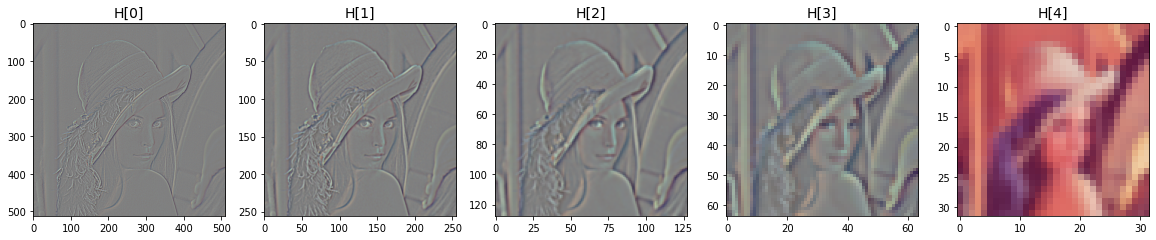

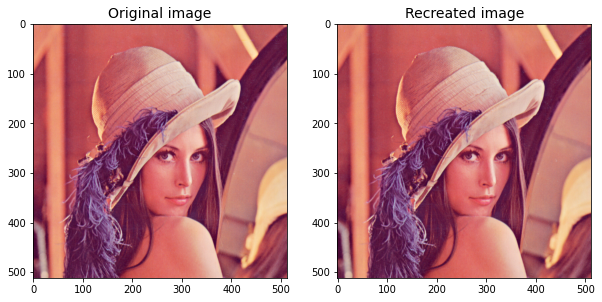

In [ ]:
HTTP_response = urllib.request.urlopen('http://www.image.ntua.gr/~tpar/LABimage/lena.png')
arr = np.asarray(bytearray(HTTP_response.read()), dtype=np.uint8)
BGR = cv2.imdecode(arr,-1)
lena = cv2.cvtColor(BGR, cv2.COLOR_BGR2RGB)
# plt.imshow(lena)

# Lpyramid
H = LPyramid(lena, a, depth)

f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20, 20))
ax0.imshow(H[0]) # Base of the pyramid
ax0.set_title('H[0]', fontsize=14)
ax1.imshow(H[1])
ax1.set_title('H[1]', fontsize=14)
ax2.imshow(H[2])
ax2.set_title('H[2]', fontsize=14)
ax3.imshow(H[3])
ax3.set_title('H[3]', fontsize=14)
ax4.imshow(H[4])
ax4.set_title('H[4]', fontsize=14)

# Final Image
final_img = L_Pyramid_Decode(H, a)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
ax0.imshow(lena)
ax0.set_title('Original image', fontsize=14)
ax1.imshow(final_img)
ax1.set_title('Recreated image', fontsize=14)



#####Grayscale εικόνα (camera)

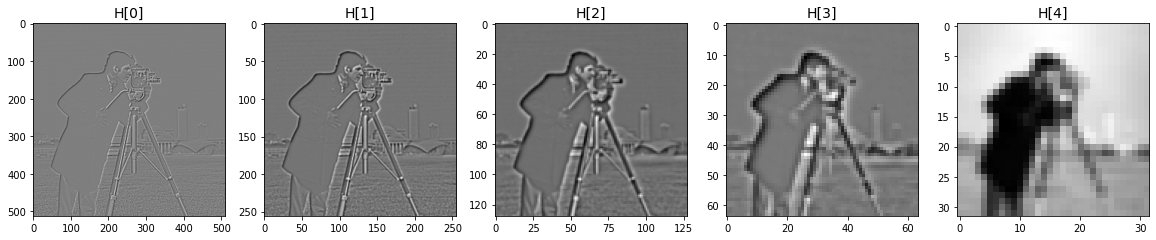

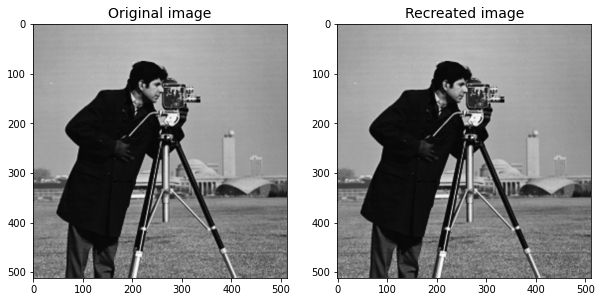

In [ ]:
from skimage import data
camera = data.camera()

# plt.imshow(camera, cmap="gray")

# Lpyramid
H = LPyramid(camera, a, depth)

f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20, 20))
ax0.imshow(H[0], cmap="gray") # Base of the pyramid
ax0.set_title('H[0]', fontsize=14)
ax1.imshow(H[1], cmap="gray")
ax1.set_title('H[1]', fontsize=14)
ax2.imshow(H[2], cmap="gray")
ax2.set_title('H[2]', fontsize=14)
ax3.imshow(H[3], cmap="gray")
ax3.set_title('H[3]', fontsize=14)
ax4.imshow(H[4], cmap="gray")
ax4.set_title('H[4]', fontsize=14)

# Final Image
final_img = L_Pyramid_Decode(H, a)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
ax0.set_title('Original image', fontsize=14)
ax0.imshow(camera, cmap="gray")
ax1.set_title('Recreated image', fontsize=14)
ax1.imshow(final_img, cmap="gray")



####β) Εμφανίστε την αρχική και την αποκωδικοποιημένη εικόνα, χρησιμοποιώντας διαφορετικά ‘a’ με τιμές να κυμαίνονται στο διάστημα [0.2,..,0.7].


#####Εγχρωμη εικόνα (Lena)

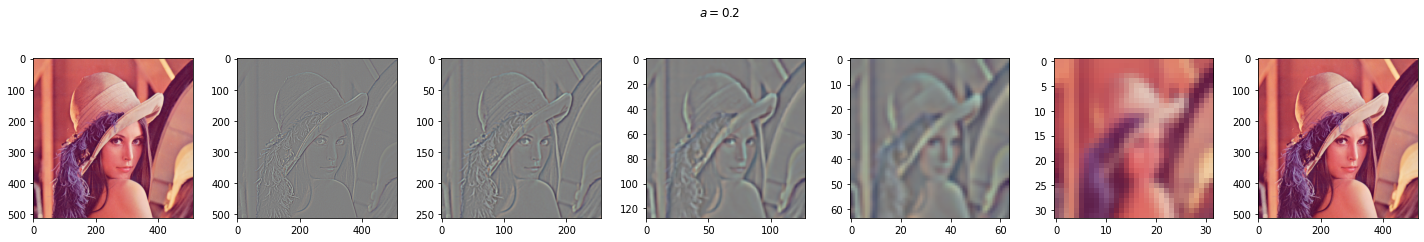

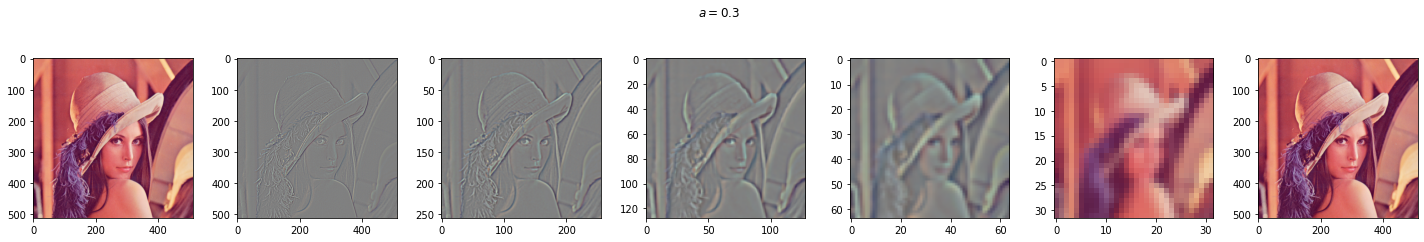

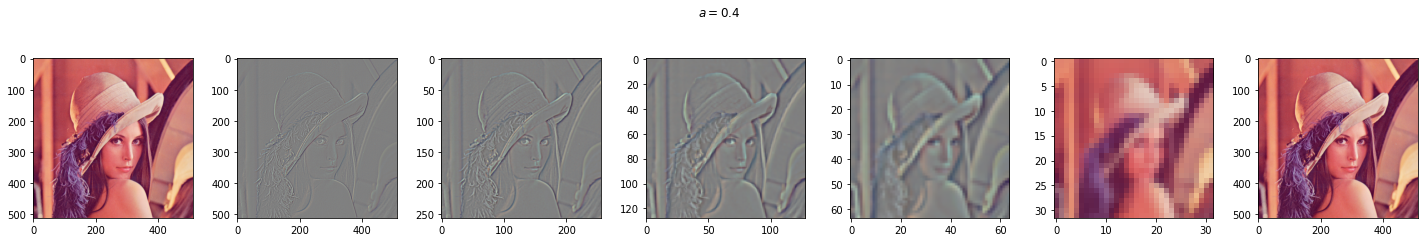

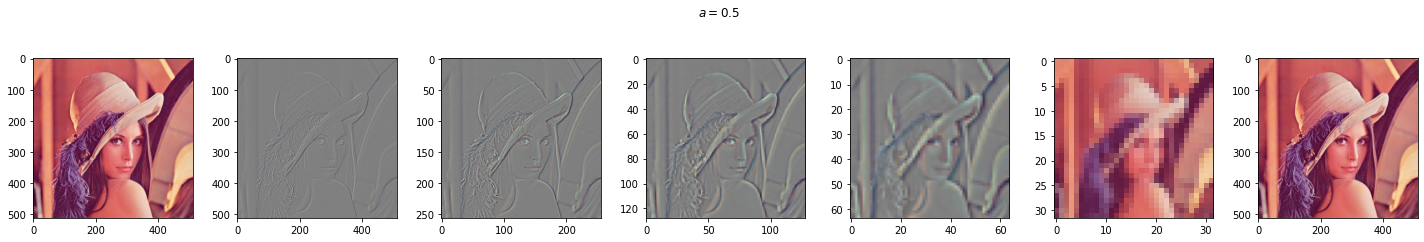

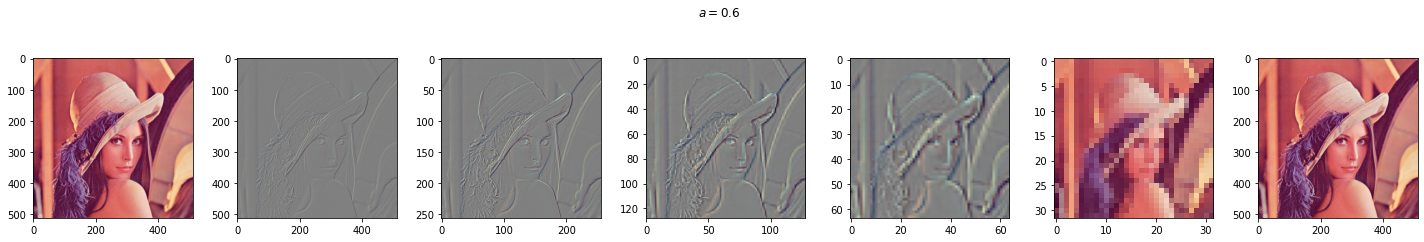

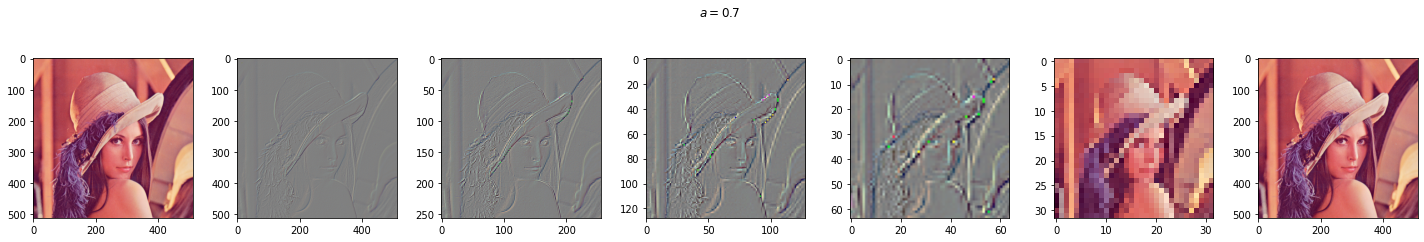

In [ ]:
for a in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:

  H = LPyramid(lena, a, depth)

  figure, axis = plt.subplots(1, len(H) + 2, figsize = (20, 4))
  figure.suptitle('$a = {}$'.format(a))
  figure.tight_layout()
  axis[0].imshow(lena)
  i = 1
  for im in H:
    axis[i].imshow(im)
    i += 1
  dec = L_Pyramid_Decode(H, a)
  axis[-1].imshow(dec)

#####Grayscale εικόνα (camera)

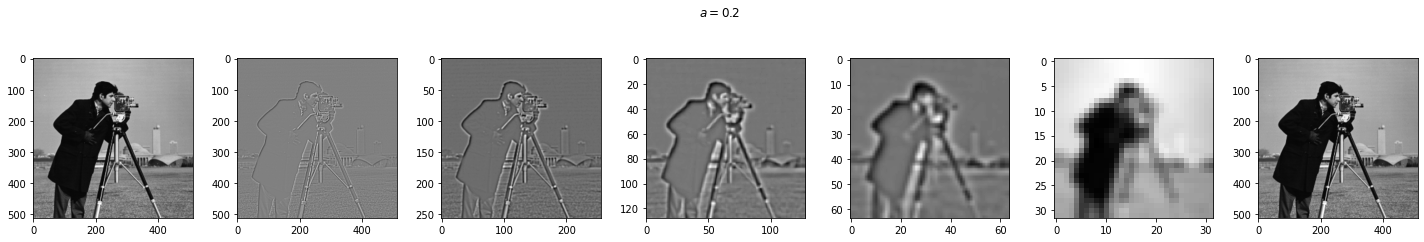

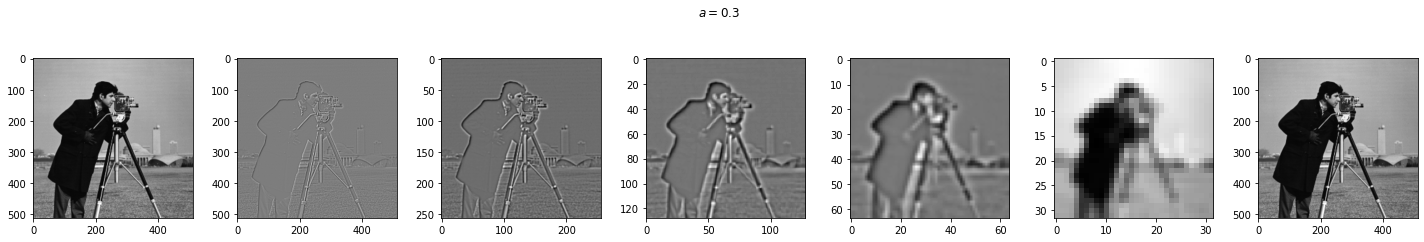

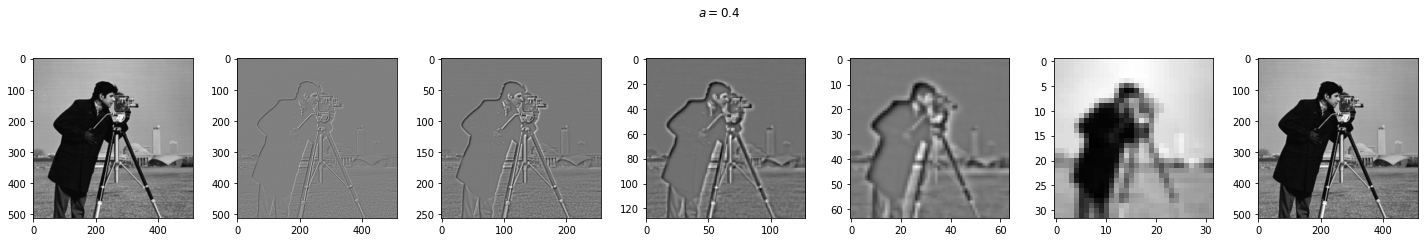

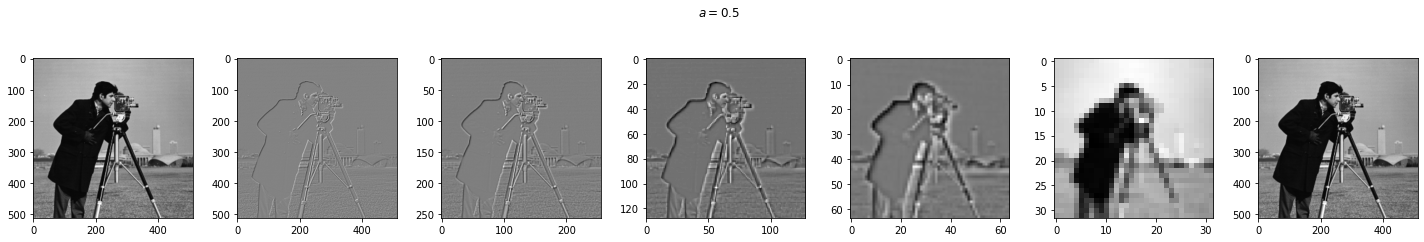

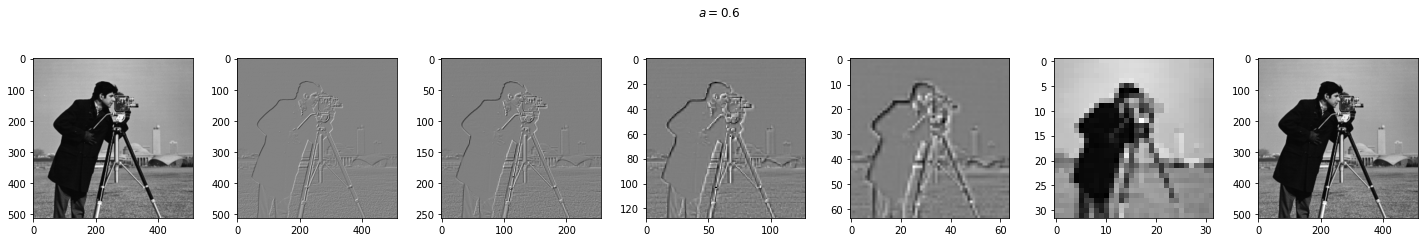

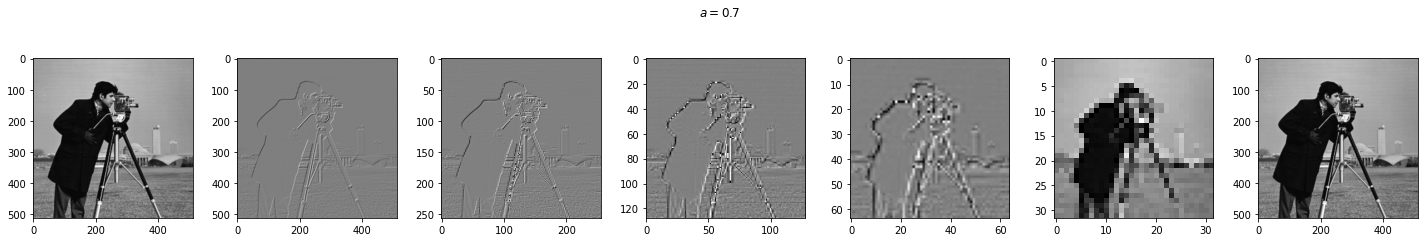

In [ ]:
for a in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:

  H = LPyramid(camera, a, depth)

  figure, axis = plt.subplots(1, len(H) + 2, figsize = (20, 4))
  figure.suptitle('$a = {}$'.format(a))
  figure.tight_layout()
  axis[0].imshow(camera, cmap="gray")
  i = 1
  for im in H:
    axis[i].imshow(im, cmap="gray")
    i += 1
  dec = L_Pyramid_Decode(H, a)
  axis[-1].imshow(dec, cmap="gray")

####γ) Εμφανίστε την αρχική και την αποκωδικοποιημένη εικόνας, χρησιμοποιώντας διαφορετικά‘depth’ με τιμές να κυμαίνονται στο διάστημα [2,..,7].


#####Εγχρωμη εικόνα (Lena)

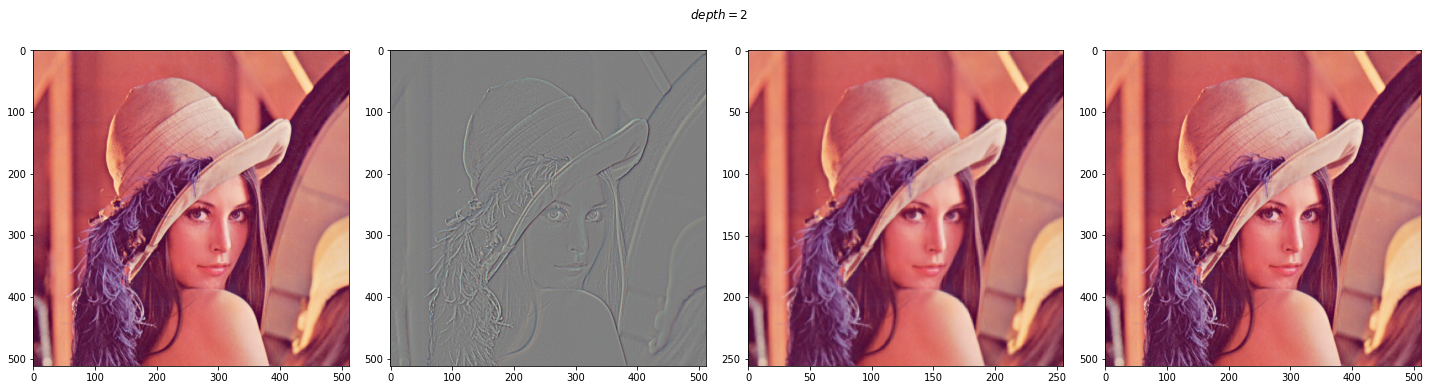

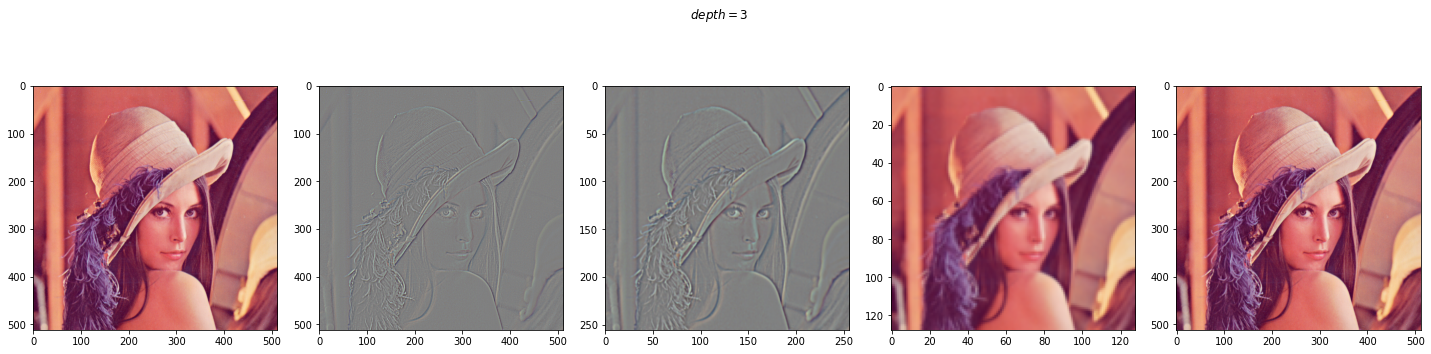

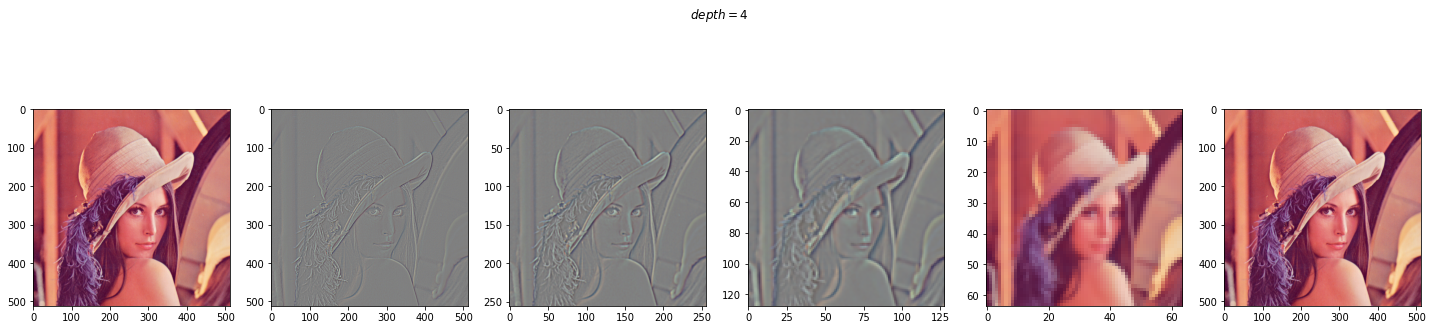

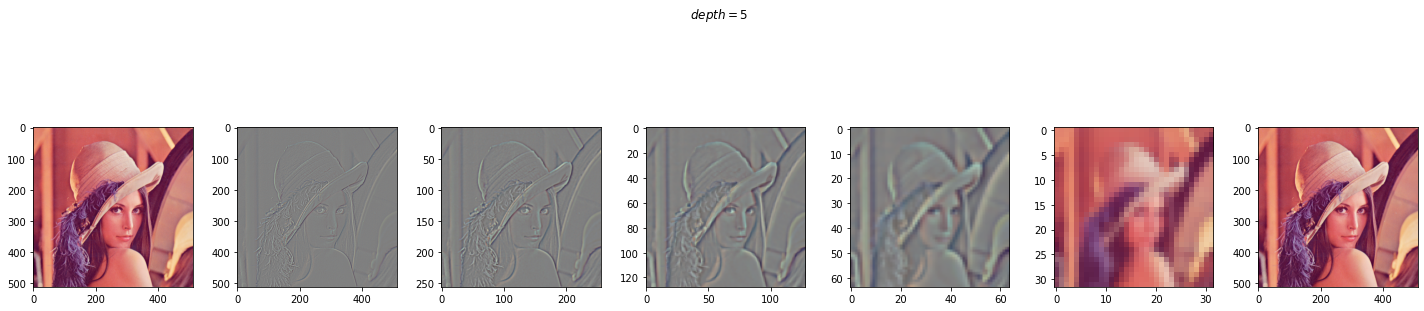

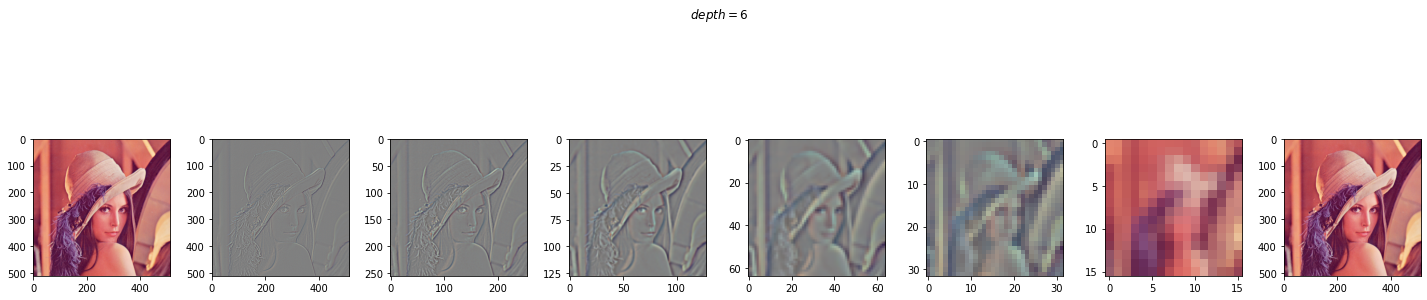

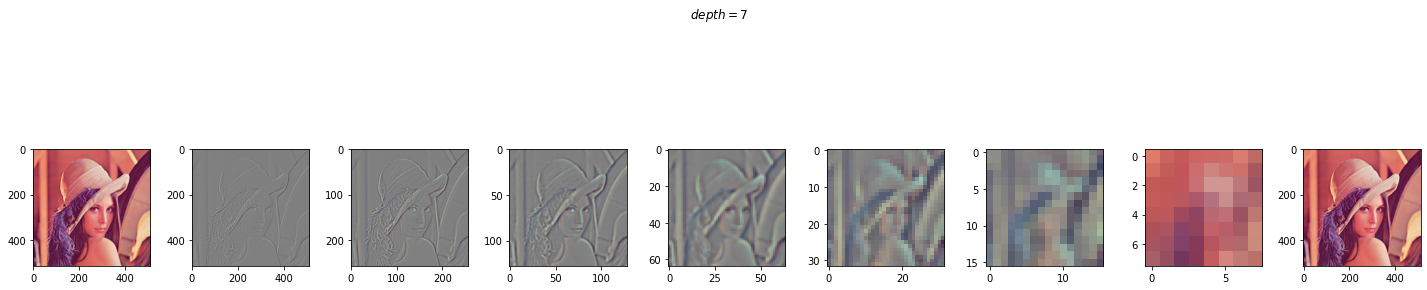

In [ ]:
a = 3/8
for depth in [2, 3, 4, 5, 6, 7]:

  H = LPyramid(lena, a, depth)

  figure, axis = plt.subplots(1, len(H) + 2, figsize = (20, 6))
  figure.suptitle('$depth = {}$'.format(depth))
  figure.tight_layout()
  axis[0].imshow(lena)
  i = 1
  for im in H:
    axis[i].imshow(im)
    i += 1
  dec = L_Pyramid_Decode(H, a)
  axis[-1].imshow(dec)

#####Grayscale εικόνα (camera)

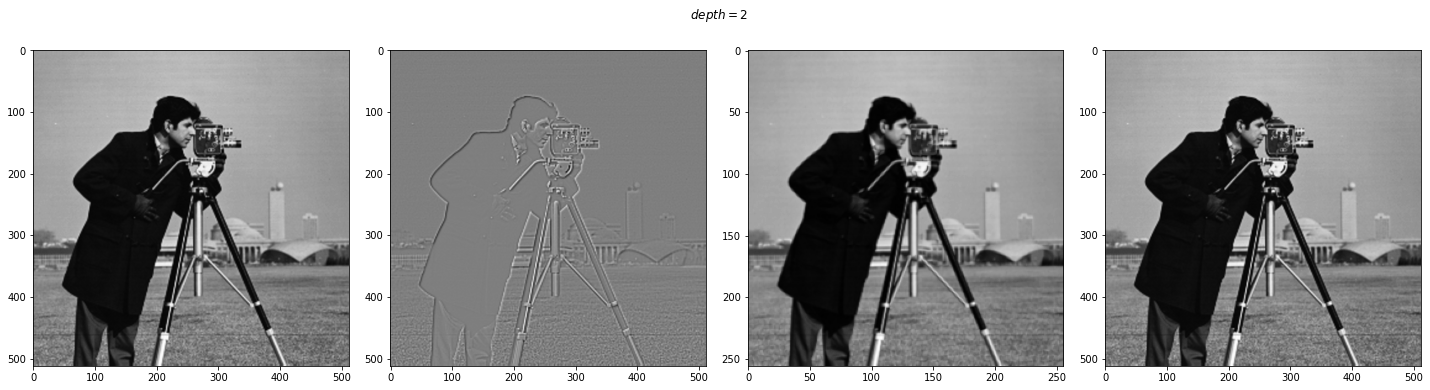

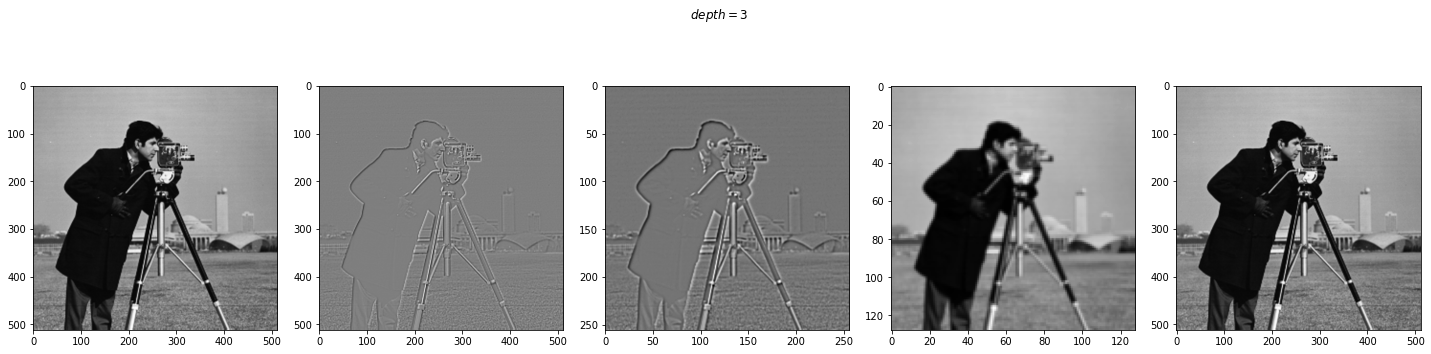

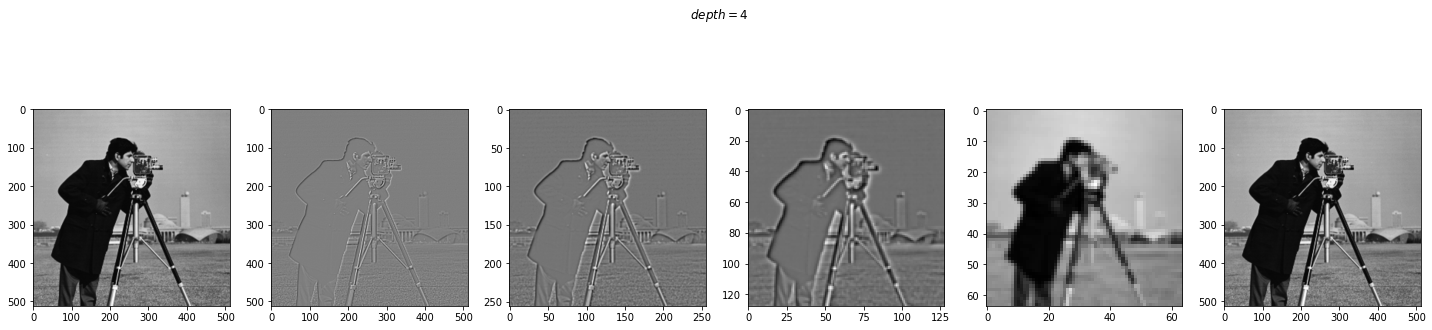

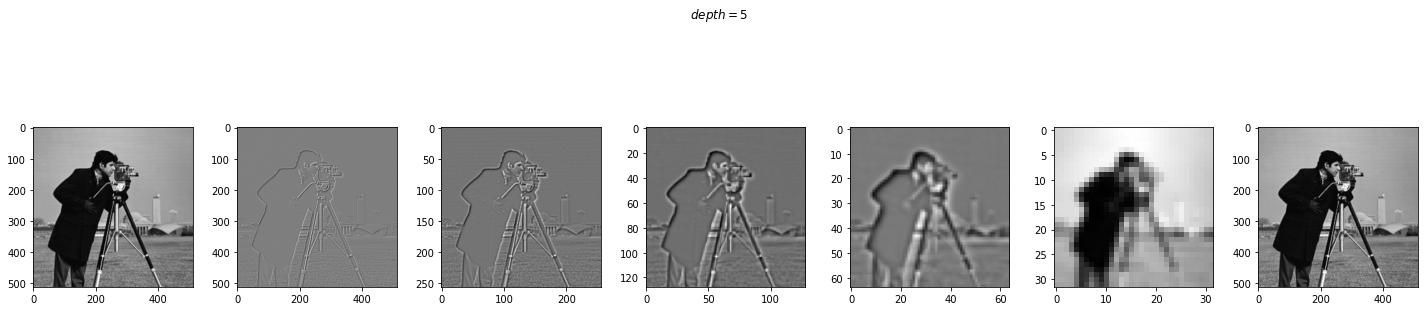

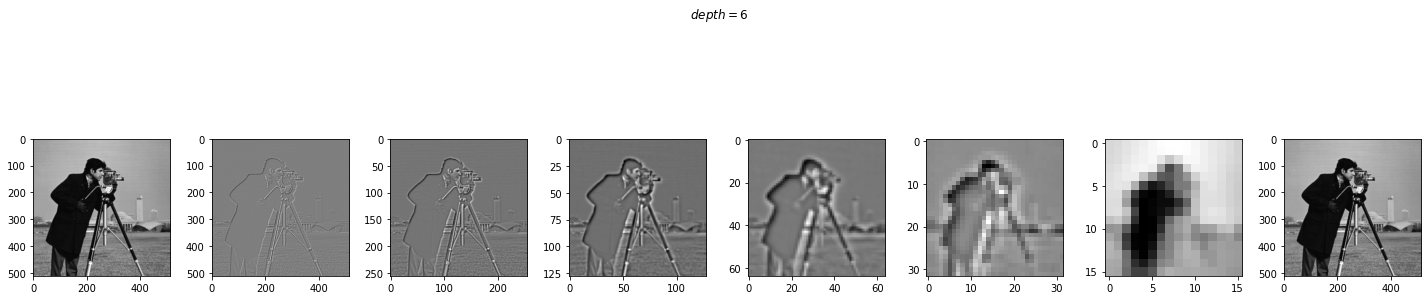

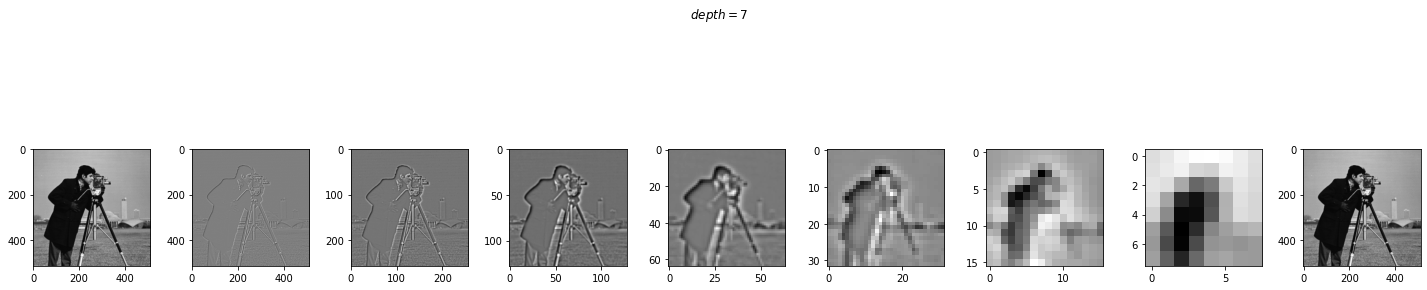

In [ ]:
a = 3/8
for depth in [2, 3, 4, 5, 6, 7]:

  H = LPyramid(camera, a, depth)

  figure, axis = plt.subplots(1, len(H) + 2, figsize = (20, 6))
  figure.suptitle('$depth = {}$'.format(depth))
  figure.tight_layout()
  axis[0].imshow(camera, cmap="gray")
  i = 1
  for im in H:
    axis[i].imshow(im, cmap="gray")
    i += 1
  dec = L_Pyramid_Decode(H, a)
  axis[-1].imshow(dec, cmap="gray")

####δ) Υπολογίστε τη εντροπία και παρουσιάστε τα αντίστοιχα διαγράμματα για τα διαφορετικά ‘a’, και ‘depth’ , για κάθε εικόνα και σχολιάστε επαρκώς

In [ ]:
import scipy.stats as st

#####Εγχρωμη εικόνα (Lena)

Entropy of the pyramid for a 0.2 and depth 5 =  2.8898543683227675
Entropy of the pyramid for a 0.3 and depth 5 =  2.840035005052911
Entropy of the pyramid for a 0.4 and depth 5 =  2.7878226280548772
Entropy of the pyramid for a 0.5 and depth 5 =  2.746713504507115
Entropy of the pyramid for a 0.6 and depth 5 =  2.7425901463547957
Entropy of the pyramid for a 0.7 and depth 5 =  2.839080481730132


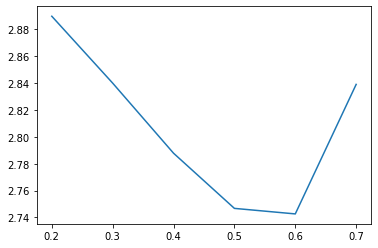

Entropy of the pyramid for a 0.375 and depth 2 =  3.802935707274264
Entropy of the pyramid for a 0.375 and depth 3 =  3.173518491372588
Entropy of the pyramid for a 0.375 and depth 4 =  2.9091966146797263
Entropy of the pyramid for a 0.375 and depth 5 =  2.7971396443711236
Entropy of the pyramid for a 0.375 and depth 6 =  2.75717189471214
Entropy of the pyramid for a 0.375 and depth 7 =  2.7444370376697473


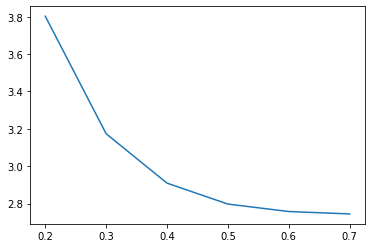

In [ ]:
# for different a
entropies = []
depth = 5

for a in [0.2,0.3,0.4,0.5,0.6,0.7]:

  H = LPyramid(lena, a, depth)
  sum_hist = np.zeros([256,1], np.float64)
  for n in H:
    hist = cv2.calcHist(n, [0], None, [256], [0,256])
    sum_hist += hist 
  # entropy = st.entropy(sum_hist, base=2)[0]
  entropy = st.entropy(sum_hist)[0]

  print("Entropy of the pyramid for a "+str(a)+" and depth "+str(depth)+" = ", entropy)
  entropies.append(entropy)

plt.plot(a_list, entropies)
plt.show()

# for different depth
entropies = []
a = 3/8

for depth in [2,3,4,5,6,7]:

  H = LPyramid(lena, a, depth)
  sum_hist = np.zeros([256,1], np.float64)
  for n in H:
    hist = cv2.calcHist(n, [0], None, [256], [0,256])
    sum_hist += hist 
  # entropy = st.entropy(sum_hist, base=2)[0]
  entropy = st.entropy(sum_hist)[0]

  print("Entropy of the pyramid for a "+str(a)+" and depth "+str(depth)+" = ", entropy)
  entropies.append(entropy)

plt.plot(a_list, entropies)
plt.show()


#####Grayscale εικόνα (camera)

Entropy of the pyramid for a 0.2 and depth 5 =  1.747856824368145
Entropy of the pyramid for a 0.3 and depth 5 =  1.7147801070970448
Entropy of the pyramid for a 0.4 and depth 5 =  1.6386485419610985
Entropy of the pyramid for a 0.5 and depth 5 =  1.6385624156143819
Entropy of the pyramid for a 0.6 and depth 5 =  1.675297607085604
Entropy of the pyramid for a 0.7 and depth 5 =  1.920352385782294


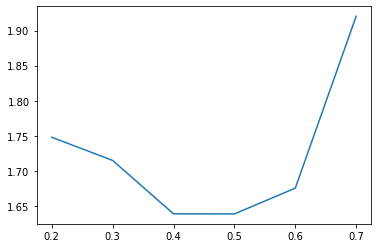

Entropy of the pyramid for a 0.375 and depth 2 =  2.816904606326883
Entropy of the pyramid for a 0.375 and depth 3 =  2.177447090763521
Entropy of the pyramid for a 0.375 and depth 4 =  1.8339143249308063
Entropy of the pyramid for a 0.375 and depth 5 =  1.6617725649031323
Entropy of the pyramid for a 0.375 and depth 6 =  1.5794263384270433
Entropy of the pyramid for a 0.375 and depth 7 =  1.582789698396493


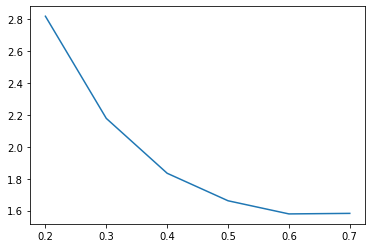

In [ ]:
# for different a
entropies = []
depth = 5

for a in [0.2,0.3,0.4,0.5,0.6,0.7]:

  H = LPyramid(camera, a, depth)
  sum_hist = np.zeros([256,1], np.float64)
  for n in H:
    hist = cv2.calcHist(n, [0], None, [256], [0,256])
    sum_hist += hist 
  # entropy = st.entropy(sum_hist, base=2)[0]
  entropy = st.entropy(sum_hist)[0]

  print("Entropy of the pyramid for a "+str(a)+" and depth "+str(depth)+" = ", entropy)
  entropies.append(entropy)

plt.plot(a_list, entropies)
plt.show()

# for different depth
entropies = []
a = 3/8

for depth in [2,3,4,5,6,7]:

  H = LPyramid(camera, a, depth)
  sum_hist = np.zeros([256,1], np.float64)
  for n in H:
    hist = cv2.calcHist(n, [0], None, [256], [0,256])
    sum_hist += hist 
  # entropy = st.entropy(sum_hist, base=2)[0]
  entropy = st.entropy(sum_hist)[0]

  print("Entropy of the pyramid for a "+str(a)+" and depth "+str(depth)+" = ", entropy)
  entropies.append(entropy)

plt.plot(a_list, entropies)
plt.show()


####ε) Εντοπίστε το βέλτιστο ‘a’, χρησιμοποιώντας την εντροπία και τη διακύμανση των τιμών των εικονοστοιχείων σε κάθε επίπεδο της πυραμίδας Laplacian, για κάθε εικόνα.


####στ) Για το βέλτιστο ‘a’ που υπολογίσατε στο προηγούμενο ερώτημα, κβαντίστε τις εικόνες Lena και camera χρησιμοποιώντας διαφορετικά bin size (πραγματοποιήστε 3 διαφορετικά πειράματα για κάθε εικόνα)

####ζ) Υπολογίστε και σχολιάστε το SNR της αρχικής και των ανακατασκευασμένων της εικόνων (τις 3 διαφορετικές εικόνες που προέκυψαν από τα 3 διαφορετικά πειράματα), για κάθε εικόνα ( Lena και camera).
